In [1]:
import tensorflow as tf

In [2]:
def weight_variable(shape):
    return tf.Variable(tf.random_normal(shape, mean=0.0, stddev=0.01))

def bias_variable(shape):
    return tf.Variable(tf.random_normal(shape, mean=0.0, stddev=0.01))

def layer(x, shape, activation):
    W = weight_variable(shape)
    b = bias_variable([shape[1]])
    return activation(tf.matmul(x, W) + b)

In [3]:
def get_batch(images, batch_size, index):
    start_idx = index * batch_size
    end_idx = (index + 1) * batch_size        
    batch  = images[start_idx: end_idx]
    return batch

In [4]:
#image_size = 28 * 28
#latent_dim=2
#encoder_internal_dim=2048
#decoder_internal_dim=2048

image_size = 64 * 64 * 3
latent_dim=10
input_shape = [None, image_size]
encoder_internal_dim = decoder_internal_dim = 4096


x = tf.placeholder(tf.float32, input_shape)

softplus = tf.nn.softplus

h_enc1 = layer(x, [image_size, encoder_internal_dim], activation=softplus)
h_enc2 = layer(h_enc1, [encoder_internal_dim, encoder_internal_dim], activation=softplus)
h_enc3 = layer(h_enc2, [encoder_internal_dim, encoder_internal_dim], activation=softplus)

W_mu = weight_variable([encoder_internal_dim, latent_dim])
b_mu = bias_variable([latent_dim])

W_log_sigma = weight_variable([encoder_internal_dim, latent_dim])
b_log_sigma = bias_variable([latent_dim])

    
z_mu = tf.matmul(h_enc3, W_mu) + b_mu
z_log_sigma = tf.matmul(h_enc3, W_log_sigma) + b_log_sigma

# reparametarization trick

# noise gaussian ε ~ N(0, 1)
epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], latent_dim]))

# z = μ+σ^(1/2)*ε
z = z_mu + tf.exp(z_log_sigma/2) * epsilon


h_dec1 = layer(z, [latent_dim, decoder_internal_dim], activation=softplus)
h_dec2 = layer(h_dec1, [decoder_internal_dim, decoder_internal_dim], activation=softplus)
h_dec3 = layer(h_dec2, [decoder_internal_dim, decoder_internal_dim], activation=softplus)

# log(p(x|z)) (p is Bernoulli) reconstruction loss
y = layer(h_dec3, [decoder_internal_dim, image_size], activation=tf.nn.sigmoid)
recon = -tf.reduce_sum(x * tf.log(y + 1e-10) + (1 - x) * tf.log(1 - y + 1e-10), 1)


# KLD(q(z|x)||p(z)) ~ -(1/2) * sum(1 + log(sigma^2) - mu^2 - sigma^2)
kl_div = - (1/2)* tf.reduce_sum(1.0 + 2.0 * z_log_sigma - tf.square(z_mu) - tf.exp(2.0 * z_log_sigma),1)

 

cost = tf.reduce_mean(recon + kl_div)
cost_kl = tf.reduce_mean(kl_div)
cost_recon = tf.reduce_mean(recon)


In [5]:
% rm -rf img/
% mkdir img/

import matplotlib.pyplot as plt
import numpy as np


def create_images(i, sess, test_images, num_examples=20, image_size=28*28):
    h = w = int(np.sqrt(image_size/3))
    
    original = get_batch(test_images, num_examples, 0)
    reconstruction = sess.run(y, feed_dict={x: original})
    
    fig, axs = plt.subplots(2, num_examples, figsize=(20, 2))
    for example_i in range(num_examples):
        axs[0][example_i].imshow(np.reshape(original[example_i, :], (h, w, 3)),cmap='gray')
        axs[1][example_i].imshow(np.reshape(np.reshape(reconstruction[example_i, ...], (image_size,)),(h, w, 3)),cmap='gray')
        #axs[0][example_i].imshow(np.reshape(original[example_i, :], (h, w)),cmap='gray')
        #axs[1][example_i].imshow(np.reshape(np.reshape(reconstruction[example_i, ...], (image_size,)),(h, w)),cmap='gray')
        axs[0][example_i].axis('off')
        axs[1][example_i].axis('off')
    fig.savefig('img/reconstruction_%08d.png' % i)

    
    

def create_latent_scatter_images(i, sess, test_images,test_labels):
    zs = sess.run(z, feed_dict={x: test_images})
    fig, ax = plt.subplots(1, 1)
    ax.clear()
    ax.scatter(zs[:, 0], zs[:, 1], c=np.argmax(test_labels, 1), alpha=0.2)
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.axis("off")
    fig.savefig("img/latent_scatter_%08d.png"% i)

In [18]:
def train(train_images, validation_images, test_images, test_labels=[], image_size=28*28, learning_rate = 0.001):

    sess = tf.Session()
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    sess.run(tf.global_variables_initializer())

    
    batch_size = 100
    num_epochs = 100

    num_train_batches = len(train_images) // batch_size
    num_validation_batches = len(validation_images) // batch_size

    print("num of train batches: ", num_train_batches)
    print("num of validation batches: ", num_validation_batches)

    i = 0
    for epoch in range(num_epochs):
        print("epoch No.", epoch)
        
        for batch_idx in range(num_train_batches):            
            batch  = get_batch(train_images, batch_size, batch_idx)
            sess.run(optimizer, feed_dict={x: batch})
            print("h_dec3: ", sess.run(h_dec3, feed_dict={x: batch}))
            print("y: ", sess.run(y, feed_dict={x: batch}))
      
            
         
        train_cost = sess.run(cost, feed_dict={x: batch})
        print("train cost per a batch: ", train_cost)
        i += 1
        create_images(i, sess, test_images, num_examples=10, image_size=image_size)
        #create_images(i, sess, test_images, num_examples=20, image_size=image_size)
        #create_latent_scatter_images(i, sess, test_images, test_labels)
        print("cost_kl: ", sess.run(cost_kl, feed_dict={x: batch}))
        print("cost_recon: ", sess.run(cost_recon, feed_dict={x: batch}))
      

        valid_cost = 0
        for j in range(num_validation_batches):
            batch  = get_batch(validation_images, batch_size, j)
            valid_cost += sess.run(cost, feed_dict={x: batch})
        print("validation cost per a batch: ", valid_cost / num_validation_batches)


In [7]:
from glob import glob
import os
import scipy
import scipy.misc
import tqdm


%matplotlib inline  
data = glob(os.path.join("celebA", "*.jpg"))
data = np.sort(data)
data[0:10]

array(['celebA/000151.jpg', 'celebA/001038.jpg', 'celebA/001087.jpg',
       'celebA/001252.jpg', 'celebA/001495.jpg', 'celebA/001587.jpg',
       'celebA/001666.jpg', 'celebA/001851.jpg', 'celebA/002324.jpg',
       'celebA/002373.jpg'],
      dtype='<U17')

In [8]:
len(data)

822

In [9]:
def imread(path):
    return scipy.misc.imread(path).astype(np.float)

def resize_width(image, width=64.):
    h, w = np.shape(image)[:2]
    return scipy.misc.imresize(image,[int((float(h)/w)*width),width])
        
def center_crop(x, height=64):
    h= np.shape(x)[0]
    j = int(round((h - height)/2.))
    return x[j:j+height,:,:]

def get_image(image_path, width=64, height=64):
    return center_crop(resize_width(imread(image_path), width = width),height=height)

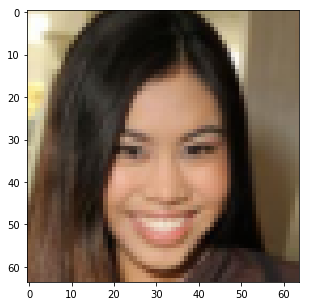

In [10]:
dim = int(np.sqrt(image_size/3))
test = get_image(data[0],dim,dim)
cm = plt.cm.hot
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5))
ax.imshow(np.reshape(test, (dim,dim,3)), interpolation='nearest')


In [11]:
#images = np.zeros((len(data),dim,dim,3), dtype = np.float)

images = np.zeros((len(data),dim*dim*3), dtype = np.float)
for i, d in enumerate(tqdm.tqdm(data)):
    image = get_image(d, dim,dim)
    images[i] = image.flatten()/255.

100%|██████████| 822/822 [00:03<00:00, 263.28it/s]


In [12]:
images[0].shape

(12288,)

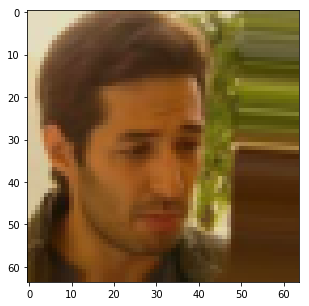

In [13]:
test = images[i]
cm = plt.cm.hot
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5))
ax.imshow(np.reshape(test, (dim,dim,3)), interpolation='nearest')

In [14]:
train_images = validation_images = images
test_images = images[:10]

In [ ]:
train(train_images, validation_images, test_images, test_labels=[], image_size=64*64*3,learning_rate = 0.001)

num of train batches:  8
num of validation batches:  8
epoch No. 0
h_dec3:  [[  0.00000000e+00   0.00000000e+00   1.81354965e+19 ...,   0.00000000e+00
    2.19801632e+19   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.26470624e+25 ...,   0.00000000e+00
    1.53248321e+25   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   3.04420838e+28 ...,   0.00000000e+00
    3.51026180e+28   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   2.34396166e+27 ...,   0.00000000e+00
    2.84295789e+27   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.22912244e+29 ...,   0.00000000e+00
    1.41731686e+29   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.22954028e+27 ...,   0.00000000e+00
    1.49112219e+27   0.00000000e+00]]


In [ ]:
# mnist

In [ ]:
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets('MNIST_DATA', one_hot=True)

In [ ]:
train_images = mnist.train.images
validation_images = mnist.validation.images
test_images = mnist.test.images
test_labels = mnist.test.labels

In [ ]:
train_images[0].shape

In [ ]:
train(train_images, validation_images, test_images, test_labels, image_size=28*28)